In [ ]:
!pip install -q kaggle
     

# upload kaggle.json
from google.colab import files
files.upload()

!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!ls ~/.kaggle

!kaggle datasets download -d madisona/translated-animals10

Saving kaggle.json to kaggle.json
kaggle.json
100% 586M/586M [00:28<00:00, 11.7MB/s]
100% 586M/586M [00:28<00:00, 21.4MB/s]


In [ ]:
!mkdir animals
!unzip -qq translated-animals10.zip -d animals
!ls animals


animals10


In [ ]:
!ls animals/animals10/raw-img/

butterfly  cat	chicken  cow  dog  elephant  horse  sheep  spider  squirrel


In [ ]:
import os

animals = os.path.join('/content/animals/animals10/raw-img/')

print(os.listdir(animals))

['elephant', 'cat', 'sheep', 'spider', 'butterfly', 'cow', 'chicken', 'dog', 'horse', 'squirrel']


In [ ]:
import shutil

ignore_animals = ['spider', 'dog', 'chicken', 'sheep', 'cow', 'horse']

for x in ignore_animals:
  path = os.path.join(animals, x)
  shutil.rmtree(path)

In [ ]:
list_animals = os.listdir(animals)
print(list_animals)

['elephant', 'cat', 'butterfly', 'squirrel']


In [ ]:
from PIL import Image
total = 0

for x in list_animals:
  dir = os.path.join(animals, x)
  y = len(os.listdir(dir))
  print(x+':', y)
  total = total + y
  
  img_name = os.listdir(dir)
  for z in range(4):
    img_path = os.path.join(dir, img_name[z])
    img = Image.open(img_path)
    print('-',img.size)
  print('---------------')

print('\nTotal :', total)
     

elephant: 1446
- (640, 426)
- (300, 200)
- (300, 271)
- (300, 169)
---------------
cat: 1668
- (640, 426)
- (300, 200)
- (300, 169)
- (300, 200)
---------------
butterfly: 2112
- (270, 194)
- (300, 241)
- (213, 300)
- (426, 640)
---------------
squirrel: 1862
- (300, 225)
- (300, 225)
- (201, 300)
- (300, 226)
---------------

Total : 7088


In [ ]:
import tensorflow as tf

In [ ]:
#mendefenisikan dataset
dataset = animals

In [ ]:
#mempersiapkan data latih dan data uji dengan rasio 60% data latih dan 40% data uji
from tensorflow.keras.preprocessing.image import ImageDataGenerator , load_img
from tensorflow import keras
os.makedirs("output")

train_datagen = ImageDataGenerator(
                    rescale=1./255,
                    horizontal_flip=True,
                    shear_range = 0.2,
                    fill_mode = 'wrap',
                    validation_split=0.2)

train_generator = train_datagen.flow_from_directory(
    dataset,
    batch_size=1,
    target_size=(100, 150),
    shuffle=True,
    subset='training',
    save_to_dir="output/",
    save_prefix="",
    save_format='png',
)

Found 5672 images belonging to 4 classes.


In [ ]:
batch_size = 256

data_train = train_datagen.flow_from_directory(
    dataset,
    target_size=(150, 150),
    batch_size=batch_size,
    class_mode='categorical',
    subset='training')

data_val = train_datagen.flow_from_directory(
    dataset, 
    target_size=(150, 150),
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation')

Found 5672 images belonging to 4 classes.
Found 1416 images belonging to 4 classes.


(1, 100, 150, 3)


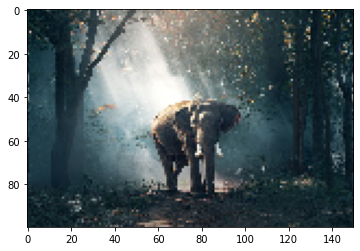

(1, 100, 150, 3)


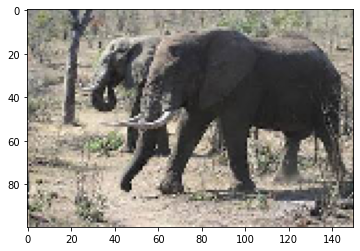

(1, 100, 150, 3)


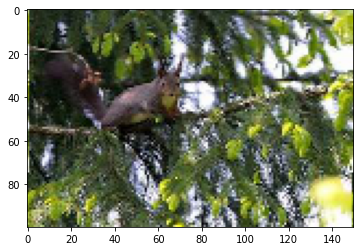

(1, 100, 150, 3)


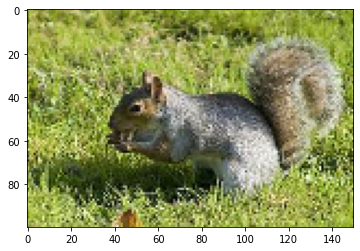

(1, 100, 150, 3)


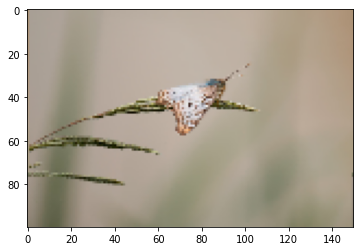

In [ ]:
#melakukan crosscheck apakah data latih sudah sesuai setelah disiapkan oleh imagedatagenerator
import matplotlib.pyplot as plt
for _ in range(5):
    img, label = train_generator.next()
    print(img.shape)
    plt.imshow(img[0])
    plt.show()

In [ ]:
#mendefenisikan model sequential
tf.device('/device:GPU:0')

model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(64, (3,3), activation='relu', input_shape=(150, 150, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.5), 
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(4, activation='softmax')
])

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics = ['accuracy'])

model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 64)      1792      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 74, 74, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 64)        36928     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 36, 36, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 34, 34, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 17, 17, 128)      0

In [ ]:
ACCURACY_THRESHOLD = 0.82

class myCallback(tf.keras.callbacks.Callback):
	def on_epoch_end(self, epoch, logs={}):
		if(logs.get('accuracy') > ACCURACY_THRESHOLD):
			print("\nReached 80% accuracy, so stopping training!!" %(ACCURACY_THRESHOLD*100))
			self.model.stop_training = True

callbacks = myCallback()

def scheduler(epoch, lr):
  if epoch < 5:
    return lr
  else:
    return lr * tf.math.exp(-0.1)

lr_schedule = tf.keras.callbacks.LearningRateScheduler(scheduler, verbose=1)

model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 64)      1792      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 74, 74, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 64)        36928     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 36, 36, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 34, 34, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 17, 17, 128)      0

In [ ]:
history = model.fit(data_train, 
                    epochs = 100, 
                    steps_per_epoch = data_train.samples // batch_size,
                    validation_data = data_val, 
                    validation_steps = data_val.samples // batch_size,
                    verbose = 1,
                    callbacks = [callbacks])

Epoch 1/100
22/22 [==============================] - 67s 2s/step - loss: 1.2817 - accuracy: 0.3894 - val_loss: 1.0750 - val_accuracy: 0.5453
Epoch 2/100
22/22 [==============================] - 53s 2s/step - loss: 1.0231 - accuracy: 0.5694 - val_loss: 0.8991 - val_accuracy: 0.6148
Epoch 3/100
22/22 [==============================] - 53s 3s/step - loss: 0.8709 - accuracy: 0.6508 - val_loss: 0.8251 - val_accuracy: 0.6641
Epoch 4/100
22/22 [==============================] - 53s 2s/step - loss: 0.7697 - accuracy: 0.7001 - val_loss: 0.8106 - val_accuracy: 0.6594
Epoch 5/100
22/22 [==============================] - 53s 2s/step - loss: 0.7605 - accuracy: 0.7014 - val_loss: 0.6778 - val_accuracy: 0.7289
Epoch 6/100
22/22 [==============================] - 55s 3s/step - loss: 0.6476 - accuracy: 0.7568 - val_loss: 0.6000 - val_accuracy: 0.7703
Epoch 7/100
22/22 [==============================] - 53s 2s/step - loss: 0.5923 - accuracy: 0.7701 - val_loss: 0.5605 - val_accuracy: 0.7906
Epoch 8/100
2

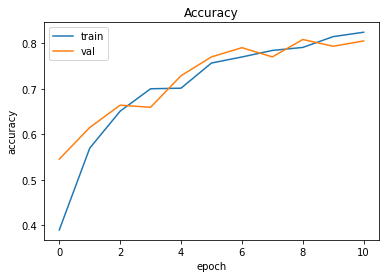

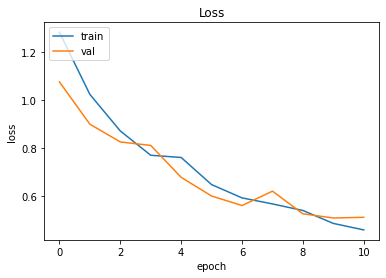

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
import warnings
# Menghilangkan Warning
warnings.filterwarnings('ignore')
# Convert Model.
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()
# Save the model.
with tf.io.gfile.GFile('model.tflite', 'wb') as f:
  f.write(tflite_model)